# Análise comparativa

## Objetivo:
O objetivo deste notebook é realizar uma análise comparativa de diferentes modelos de aprendizado de máquina aplicados à previsão da demanda por compartilhamento/locação de bicicletas. A análise busca identificar quais modelos apresentam o melhor desempenho em termos de previsão, levando em consideração a importância da preparação adequada dos dados e a aplicação de técnicas de validação robustas.

## Contexto:
A locação de bicicletas é uma solução de mobilidade urbana sustentável que tem ganhado popularidade em muitas cidades. No entanto, a previsão precisa da demanda por bicicletas é crucial para otimizar a disponibilidade e reduzir custos operacionais. Este notebook aborda o desafio de prever a demanda utilizando uma base de dados real de locação de bicicletas. A preparação dos dados e a escolha de modelos adequados são etapas fundamentais para garantir a precisão das previsões. A comparação entre diferentes modelos permitirá identificar a abordagem mais eficaz para este problema. O conjunto de dados "[Bike Sharing](https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset/data)" do Kaggle registra o uso de bicicletas compartilhadas em Washington, D.C. entre o início de 2011 a 2013. Ele inclui variáveis como data, estação do ano, se o dia é feriado ou útil, situação climática, temperatura, sensação térmica, umidade, velocidade do vento, além do número de usuários casuais, registrados e o total de aluguéis. Essas informações permitem analisar padrões de uso e construir modelos para prever a demanda de bicicletas com base em condições climáticas e temporais.

---

## Configuração Inicial:

In [1]:
from IPython.display import display, Markdown
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import ShuffleSplit, GridSearchCV, KFold, cross_validate, train_test_split, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

## 1. Preparação dos Dados:

A preparação dos dados é uma etapa essencial no desenvolvimento de modelos de aprendizado de máquina, pois garante que os dados estejam em um formato adequado para a análise e modelagem. Nesta etapa, serão realizados os seguintes processos: Tratamento de dados faltantes e discrepantes, Codificação de variáveis e Normalização dos dados.

### 1.1 Obtenção de dados

In [2]:
df = pd.read_csv("../data/raw/day.csv")
df['dteday'] = pd.to_datetime(df['dteday'])
df_dict = pd.read_csv("../data/external/dictionary.csv")
df_dict

,variavel,descricao,tipo,subtipo
0,instant,Índice de registro,quantitativa,discreta
1,dteday,Data,qualitativa,ordinal
2,season,Estação do ano,qualitativa,ordinal
3,yr,Ano,qualitativa,ordinal
4,mnth,Mês,qualitativa,ordinal
5,holiday,Se o dia é feriado ou não,qualitativa,nominal
6,weekday,Dia da semana,qualitativa,nominal
7,workingday,Se o dia não é fim de semana e nem feriado,qualitativa,nominal
8,weathersit,Clima,qualitativa,nominal
9,temp,Temperatura normalizada em Celsius,quantitativa,contínua


- A coluna `instant` trata somente do índice, então podemos removê-la.

In [3]:
df = df.drop(columns=['instant'])

### 1.2 Tratamento de dados Faltantes

In [4]:
print("Dados faltantes por coluna:")
print(df.isnull().sum())

Dados faltantes por coluna:
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


Não há dados faltantes para nenhuma das colunas na base de dados.

### 1.3 Identificação de Outliers

In [5]:
def detect_outliers_iqr(df):
    cols_to_check = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
    outliers_dict = {}

    for col in cols_to_check:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        num_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outliers_dict[col] = num_outliers

    for col, num_outliers in outliers_dict.items():
        print(f"'{col}': {num_outliers} outliers")

detect_outliers_iqr(df)

'temp': 0 outliers
'atemp': 0 outliers
'hum': 2 outliers
'windspeed': 13 outliers
'casual': 44 outliers
'registered': 0 outliers
'cnt': 0 outliers


### 1.4 Conversão de variáveis

In [6]:
df['dteday'] = pd.to_datetime(df['dteday'])

df['day'] = df['dteday'].dt.day

df['mnth_sin'] = np.sin(2 * np.pi * df['mnth'] / 12)
df['mnth_cos'] = np.cos(2 * np.pi * df['mnth'] / 12)

df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

df = df.drop(columns=['dteday', 'mnth', 'day'])

df.head()

,season,yr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,mnth_sin,mnth_cos,day_sin,day_cos
0,1,0,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,0.5,0.866025,0.201299,0.979530
1,1,0,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,0.5,0.866025,0.394356,0.918958
2,1,0,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,0.5,0.866025,0.571268,0.820763
3,1,0,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,0.5,0.866025,0.724793,0.688967
4,1,0,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,0.5,0.866025,0.848644,0.528964


- Como a base de dados já possui variáveis referentes a mês (`mnth`) e ano(`yr`), separamos apenas o dia. Com isso, precisamos alterar nosso dicionário de dados.
- Após a obtenção da variável `day` realizamos uma conversão cíclica na própria e na variável `mnth`.
- A variável `yr` não necessita de conversão cíclica, pois a mesma trata de apenas dois anos (2011 e 2012).
- Após a separação de `day` e da conversão cíclica dela e de `mnth` podemos remover as colunas referentes.

In [7]:
new_columns = pd.DataFrame({
    
    'variavel': [
        'mnth_sin',
        'mnth_cos',
        'day_sin',
        'day_cos'
    ],
    
    'descricao': [
        'Seno do mês do ano',
        'Cosseno do mês do ano',
        'Seno do dia no mês',
        'Coseno do dia no mês'
    ],
    
    'tipo': [
        'quantitativa',
        'quantitativa',
        'quantitativa',
        'quantitativa'
    ],
    
    'subtipo': [
        'contínua',
        'contínua',
        'contínua',
        'contínua',
    ]
})

df_dict = pd.concat([df_dict, new_columns], ignore_index=True)
df_dict = df_dict[~df_dict['variavel'].isin(['instant', 'dteday', 'mnth'])]
df_dict

,variavel,descricao,tipo,subtipo
2,season,Estação do ano,qualitativa,ordinal
3,yr,Ano,qualitativa,ordinal
5,holiday,Se o dia é feriado ou não,qualitativa,nominal
6,weekday,Dia da semana,qualitativa,nominal
7,workingday,Se o dia não é fim de semana e nem feriado,qualitativa,nominal
8,weathersit,Clima,qualitativa,nominal
9,temp,Temperatura normalizada em Celsius,quantitativa,contínua
10,atemp,Temperatura de sensação normalizada em Celsius,quantitativa,contínua
11,hum,Umidade do ar,quantitiva,contínua
12,windspeed,Velocidade do vento,quantitiva,contínua


### 1.5 Codificação de Variáveis

In [8]:
target_column = 'cnt'

nominal_columns = (
    df_dict
    .query("subtipo == 'nominal'")
    .variavel
    .to_list()
)

continuous_columns = (
    df_dict
    .query("subtipo == 'contínua'")
    .variavel
    .to_list()
)

ordinal_columns = (
    df_dict
    .query("subtipo == 'ordinal'")
    .variavel
    .to_list()
)

discrete_columns = (
    df_dict
    .query("subtipo == 'discreta' and variavel != @target_column")
    .variavel
    .to_list()
)

X = df.drop(columns=[target_column], axis=1)
y = df[target_column]

In [9]:
nominal_preprocessor = Pipeline([
    ('missing', SimpleImputer(strategy='most_frequent')), 
    ('encoding', OneHotEncoder(sparse_output=False, drop='first')),
    ('normalization', StandardScaler())
])

continuous_preprocessor = Pipeline([
    ('missing', SimpleImputer(strategy='median')),  
    ('normalization', StandardScaler()) 
])

ordinal_preprocessor = Pipeline([
    ('missing', SimpleImputer(strategy='most_frequent')),
    ('encoding', OrdinalEncoder()), 
    ('normalization', StandardScaler())
])

discrete_preprocessor = Pipeline([
    ('missing', SimpleImputer(strategy='most_frequent')), 
    ('normalization', StandardScaler()) 
])

preprocessor = ColumnTransformer([
    ('nominal', nominal_preprocessor, nominal_columns),
    ('ordinal', ordinal_preprocessor, ordinal_columns),
    ('discrete', discrete_preprocessor, discrete_columns),
    ('continuous', continuous_preprocessor, continuous_columns)
])

X_preprocessed = continuous_preprocessor.fit_transform(df[continuous_columns])
model = LinearRegression()

final_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', model)
])

In [10]:
X_prepared = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
print("Colunas após a preparação:")
print(feature_names)
X_prepared.shape

Colunas após a preparação:
['nominal__holiday_1' 'nominal__weekday_1' 'nominal__weekday_2'
 'nominal__weekday_3' 'nominal__weekday_4' 'nominal__weekday_5'
 'nominal__weekday_6' 'nominal__workingday_1' 'nominal__weathersit_2'
 'nominal__weathersit_3' 'ordinal__season' 'ordinal__yr'
 'discrete__casual' 'discrete__registered' 'continuous__temp'
 'continuous__atemp' 'continuous__hum' 'continuous__windspeed'
 'continuous__mnth_sin' 'continuous__mnth_cos' 'continuous__day_sin'
 'continuous__day_cos']


(731, 22)

In [11]:
X_prepared = preprocessor.fit_transform(X)
print("Dados pré-processados:")
print(X_prepared)

Dados pré-processados:
[[-1.71981001e-01 -4.09550521e-01 -4.07270449e-01 ...  1.22503889e+00
   2.80742348e-01  1.42286849e+00]
 [-1.71981001e-01 -4.09550521e-01 -4.07270449e-01 ...  1.22503889e+00
   5.51457250e-01  1.33643571e+00]
 [-1.71981001e-01  2.44170120e+00 -4.07270449e-01 ...  1.22503889e+00
   7.99532840e-01  1.19631827e+00]
 ...
 [-1.71981001e-01 -4.09550521e-01 -4.07270449e-01 ...  1.41418496e+00
  -5.54514783e-01  1.33643571e+00]
 [-1.71981001e-01 -4.09550521e-01 -4.07270449e-01 ...  1.41418496e+00
  -2.83799881e-01  1.42286849e+00]
 [-1.71981001e-01  2.44170120e+00 -4.07270449e-01 ...  1.41418496e+00
  -1.52876641e-03  1.45207803e+00]]


---

## 2. Seleção de modelos

Iremos análisar quatro modelos, que serão testados utilizando um método de validação, a saber:

- K-Nearest Neighbors
- Gradient Boosting
- Decision Tree
- Random Forest

Além disso, cada um desses algoritmos será testado com diferentes hiper-parametros, para que possamos encontrar o melhor modelo e a melhor configuração possível para esse modelo.

Utilizaremos as seguintes métricas para análise:

- **Neg Mean Squared Error ('neg_mean_squared_error')**: O erro quadrático médio (MSE) é a média dos quadrados das diferenças entre os valores previstos e os valores reais. É uma medida que penaliza erros maiores de forma mais severa, já que os erros são elevados ao quadrado.
- **Neg Mean Absolute Error ('neg_mean_absolute_error')**: O erro absoluto médio (MAE) é a média das diferenças absolutas entre os valores previstos e os valores reais. Ao contrário do MSE, o MAE não penaliza erros maiores mais severamente.
- **R² ('r2')**: O R², ou coeficiente de determinação, mede a proporção da variabilidade total dos dados que é explicada pelo modelo. Em outras palavras, indica o quão bem os valores previstos se ajustam aos valores reais.

In [12]:
n_splits_comparative_analysis = 10
n_folds_grid_search = 5
test_size = .2
random_state = 42
scoring = 'neg_mean_squared_error'
metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

max_iter = 1000 
models = [
    ('K-Nearest Neighbors', KNeighborsRegressor(), {
        "n_neighbors": range(3, 5, 7), 
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=random_state), {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }),
     ('Decision Tree',  DecisionTreeRegressor(random_state=random_state), {
        'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 
        'max_depth': [3, 6, 8]
    }),
    ('Random Forest',  RandomForestRegressor(random_state=random_state), {
        'criterion': ['squared_error', 'absolute_error'],
        'max_depth': [3, 6, 8], 
        'n_estimators': [10, 30]
    }),
]

In [13]:
model_results = {}
results = pd.DataFrame({})
cross_validate_grid_search = KFold(n_splits=n_folds_grid_search)
cross_validate_comparative_analysis = ShuffleSplit(n_splits=n_splits_comparative_analysis, test_size=test_size, random_state=random_state)

for model_name, model_object, model_parameters in models:
    display(Markdown(
        "<br>"
        f"running **{model_name}**... "
    ))
    
    model_grid_search = GridSearchCV(
        estimator=model_object,
        param_grid=model_parameters,
        scoring=scoring,
        n_jobs=-1,
        cv=cross_validate_grid_search
    )
    
    approach = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_grid_search)
    ])
    
    # Armazenando os resultados de y_true e y_pred
    for train_index, test_index in cross_validate_comparative_analysis.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        approach.fit(X_train, y_train)
        y_pred = approach.predict(X_test)
        
        model_results[model_name] = {
            'y_true': y_test,
            'y_pred': y_pred
        }

    # Avaliando o modelo com cross_validate
    scores = cross_validate(
        estimator=approach,
        X=X,
        y=y,
        cv=cross_validate_comparative_analysis,
        n_jobs=-1,
        scoring=metrics
    )
    
    scores_df = pd.DataFrame(scores)
    scores_df['model_name'] = model_name
    results = pd.concat([results, scores_df], ignore_index=True)
    numeric_scores_df = scores_df.select_dtypes(include=['float64', 'int64'])
    scores_aggregated = numeric_scores_df.agg(['mean', 'std'])
    display(scores_aggregated)

<br>running **K-Nearest Neighbors**... 

,fit_time,score_time,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_r2
mean,0.575667,0.048541,-570466.642956,-567.115587,0.846282
std,0.045589,0.010715,113496.769490,49.363614,0.032292


<br>running **Gradient Boosting**... 

,fit_time,score_time,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_r2
mean,105.879839,0.040049,-12431.834398,-71.221128,0.996647
std,15.270789,0.010440,3803.360883,8.868285,0.001040


<br>running **Decision Tree**... 

,fit_time,score_time,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_r2
mean,1.784025,0.064899,-65560.49368,-168.792358,0.982238
std,0.078430,0.033925,15351.58930,15.854313,0.004652


<br>running **Random Forest**... 

,fit_time,score_time,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_r2
mean,35.939904,0.090171,-19213.449554,-86.927371,0.994815
std,7.411019,0.062719,5879.075776,9.621916,0.001608


### 2.1 Resultados Gerais

In [14]:
def highlight_best(s, props=''):
    if s.name[1] != 'std':
        if s.name[0].endswith('time'):
            return np.where(s == np.nanmin(s.values), props, '')
        return np.where(s == np.nanmax(s.values), props, '')

display(Markdown("### 2.1 Resultados gerais"))
(
    results
    .groupby('model_name')
    .agg(['mean', 'std']).T
    .style
    .apply(highlight_best, props='color:white;background-color:gray;font-weight: bold;', axis=1)
    .set_table_styles([{'selector': 'td', 'props': 'text-align: center;'}])
)

### 2.1 Resultados gerais

- Gradient Boosting foi o modelo mais eficaz no geral, com o menor erro e maior coeficiente de determinação, embora tenha um custo computacional mais elevado.
- Random Forest também teve um bom desempenho, mas com um tempo de execução menor que o Gradient Boosting, o que pode ser um trade-off interessante.
- Decision Tree foi o mais rápido, mas sacrificou precisão em relação aos outros modelos.
- KNN teve um desempenho inferior em todos os aspectos, sugerindo que pode não ser a melhor escolha para este problema específico.

Esses resultados sugerem que, se o objetivo é maximizar a precisão e há tempo computacional disponível, o Gradient Boosting é a melhor opção. Se o tempo de treinamento for uma restrição, o Random Forest pode ser uma boa alternativa.

### 2.2 Visualização do desempenho dos modelos

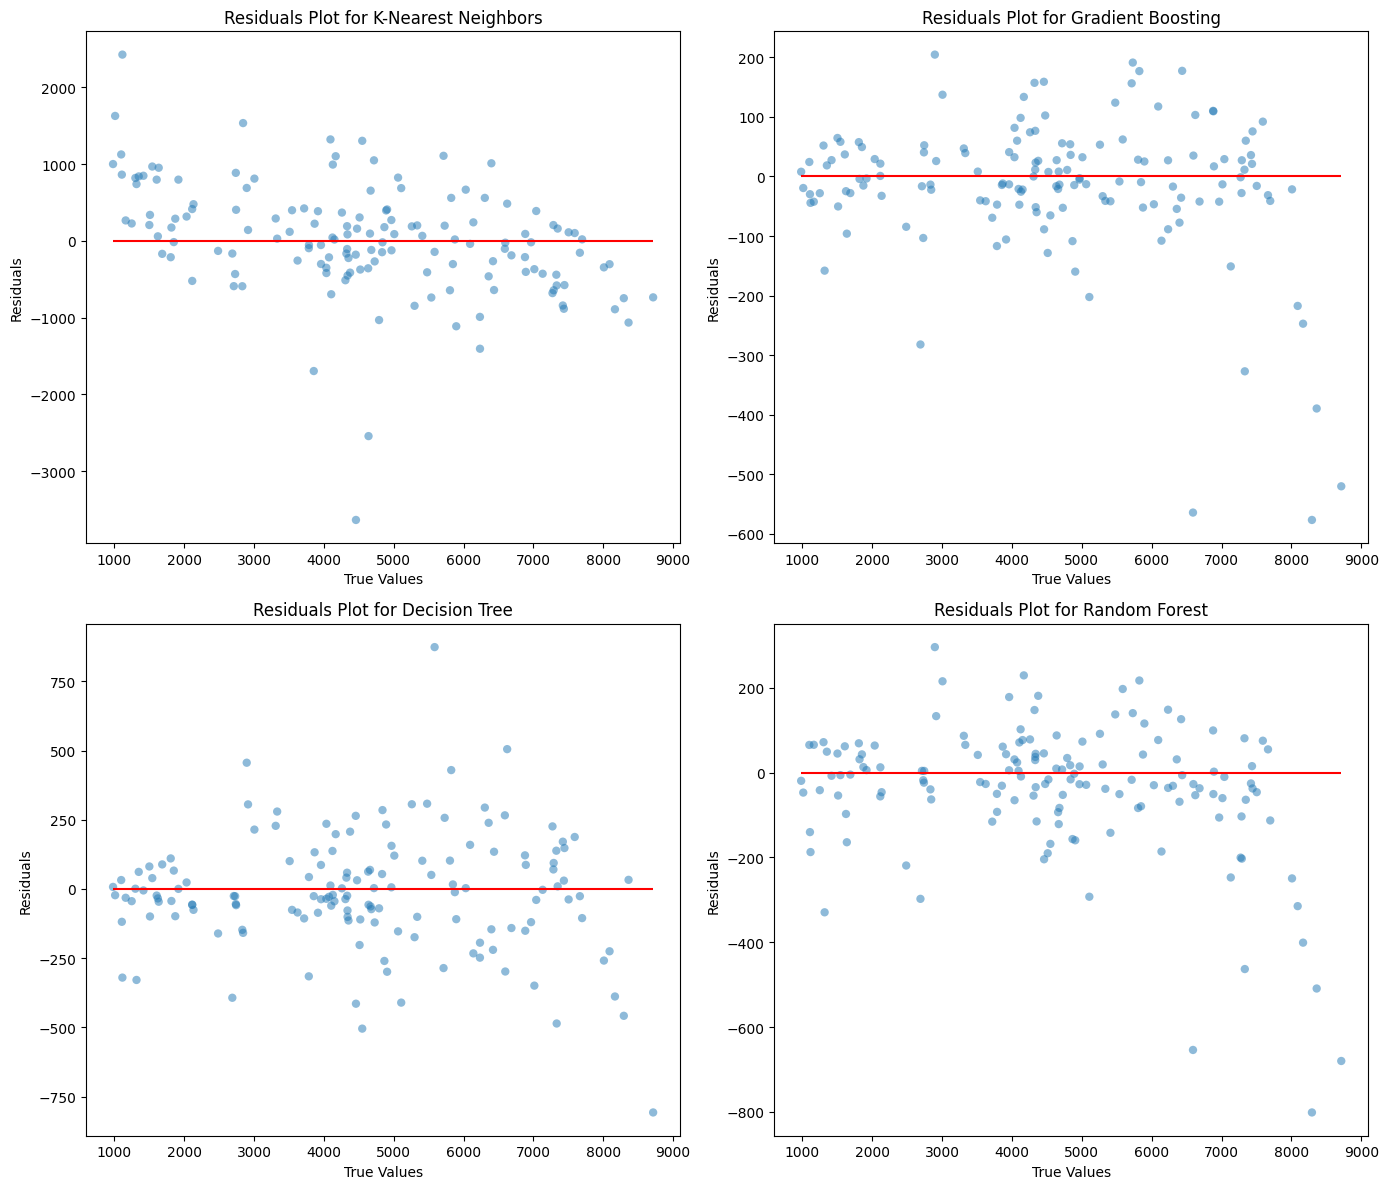

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

for i, (model_name, result) in enumerate(model_results.items()):
    row = i // 2
    col = i % 2
    
    axs[row, col].scatter(result['y_true'], result['y_pred'] - result['y_true'], alpha=0.5, edgecolor='none')
    axs[row, col].hlines(y=0, xmin=result['y_true'].min(), xmax=result['y_true'].max(), colors='r')
    axs[row, col].set_xlabel('True Values')
    axs[row, col].set_ylabel('Residuals')
    axs[row, col].set_title(f'Residuals Plot for {model_name}')


plt.tight_layout()
plt.show()

- É possível observar que o modelo Gradient Boosting apresenta menos resíduos, o que indica que os valores preditos estão mais próximos aos valores reais.

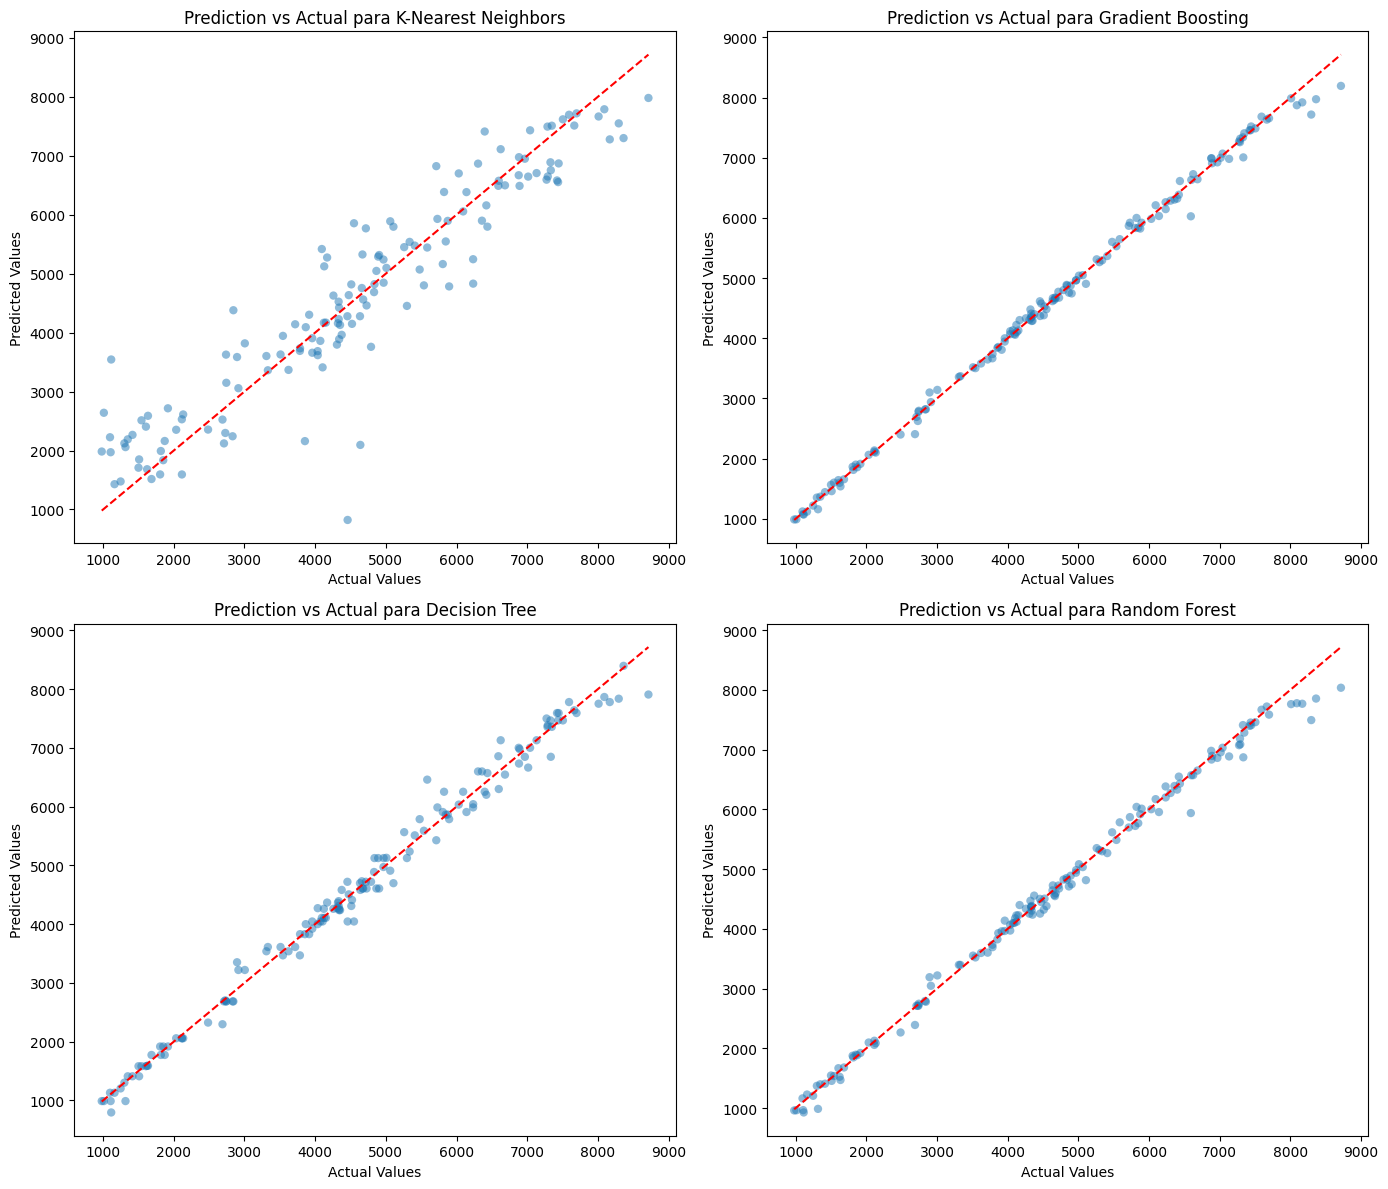

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

for i, (model_name, result) in enumerate(model_results.items()):
    row = i // 2
    col = i % 2
    
    y_true = result['y_true']
    y_pred = result['y_pred']
    
    axs[row, col].scatter(y_true, y_pred, alpha=0.5, edgecolor='none')
    axs[row, col].plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    axs[row, col].set_xlabel('Actual Values')
    axs[row, col].set_ylabel('Predicted Values')
    axs[row, col].set_title(f'Prediction vs Actual para {model_name}')

plt.tight_layout()
plt.show()

### 2.3 Persistência do modelo

In [17]:
model_name, model_object, model_parameters  = [foo for foo in models if foo[0] == "Gradient Boosting"][0] 

model_grid_search = GridSearchCV(
        estimator=model_object,
        param_grid=model_parameters,
        scoring=scoring,
        n_jobs=-1,
        cv=cross_validate_grid_search
    )

approach = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model_grid_search)
])

approach.fit(X, y)

print(f"Hiper parâmetros do modelo: {approach.steps[1][1].best_params_}")

Hiper parâmetros do modelo: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}


In [18]:
joblib.dump(approach, '../models/model.joblib')

['../models/model.joblib']